### ratio map 之大排組
各種分之 CO(1-0)

湯底是 py_HCN-CO_wask_v2.ipynb，看中它集中取名/存檔的優點  
這邊處理的數據理論上來說解析度是統一的 (by imsmooth)...所以不會再做卷積    

可以輸入東西：  
pixelStep : 投影後的一個 pixel 對應天上多少角秒

In [1]:
# modular

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u 
from reproject import reproject_interp
from radio_beam import Beam

In [ ]:
# hand made function

# 存檔芝士
def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam): 
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 新網格機！
'''
input a hdul&&像素步長 in arcsec
return new_shape, new_wcs, 和定義的 header 本人 
疑似只能用在我的 CO
'''
def reGrid(reGrid_obj, pixelStep_target): 
    reGrid_obj_header = reGrid_obj[0].header
    ori_n1, ori_n2 = reGrid_obj[0].data.squeeze().shape # (y, x)
    new_n2 = int(ori_n2*abs(reGrid_obj_header['CDELT1']) / (pixelStep_target/3600)) # 要純量相除！
    new_n1 = int(ori_n1*abs(reGrid_obj_header['CDELT2']) / (pixelStep_target/3600))
    new_header = fits.Header()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = new_n2
    new_header['NAXIS2'] = new_n1
    new_header['CRPIX1'] = new_n2 * 0.5 + 1
    new_header['CRPIX2'] = new_n1 * 0.5 + 1
    new_header['CRVAL1'] = 213.2915 # 暴力抓蟲
    new_header['CRVAL2'] = -65.339 # 暴力抓蟲
    new_header['CDELT1'] = pixelStep_target / -3600
    new_header['CDELT2'] = pixelStep_target / 3600
    new_header['CTYPE1'] = 'RA---SIN'
    new_header['CTYPE2'] = 'DEC--SIN'
    new_header['CUNIT1'] = 'deg'
    new_header['CUNIT2'] = 'deg'
    new_header['BMAJ'] = reGrid_obj_header['BMAJ']
    new_header['BMIN'] = reGrid_obj_header['BMIN']
    new_header['BPA'] = reGrid_obj_header['BPA']
    print('Giving reprojecting material...')
    return (new_n2, new_n1), WCS(new_header), new_header


In [ ]:
# import data_2

path = '/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvp_smoothFirst/3_mom0_multi-sigma/'

CO_hdul = fits.open(f"{path}CO-1-0_mom0_smoothed-4545_sigma0.2.fits")
HCN_hdul = fits.open(f"{path}HCN-1-0_mom0_smoothed-4545_sigma0.2.fits")
HCO_hdul = fits.open(f"{path}HCO+-1-0_mom0_smoothed-4545_sigma0.2.fits") # 變數名就不加算符了
CN12_hdul = fits.open(f"{path}CN-J12-12_mom0_smoothed-4545_sigma0.8.fits")
CN32_hdul = fits.open(f"{path}CN-J32-12_mom0_smoothed-4545_sigma0.8.fits")
HNC_hdul = fits.open(f"{path}HNC-1-0_mom0_smoothed-4545_sigma0.4.fits")
CS2_hdul = fits.open(f"{path}CS-J2-1_mom0_smoothed-4545_sigma0.2.fits")

CO_header, HCN_header, HCO_header, CN_header, HNC_header, CS2_header = CO_hdul[0].header, HCN_hdul[0].header, HCO_hdul[0].header, CN_hdul[0].header, HNC_hdul[0].header, CS2_hdul[0].header
CO_ima, HCN_ima, HCO_ima, CN_ima, HNC_ima, CS2_ima = CO_hdul[0].data.squeeze(), HCN_hdul[0].data.squeeze(), HCO_hdul[0].data.squeeze(), CN_hdul[0].data.squeeze(), HNC_hdul[0].data.squeeze(), CS2_hdul[0].data.squeeze()
CO_wcs, HCN_wcs, HCO_wcs, CN_wcs, HNC_wcs, CS2_wcs = WCS(CO_header, naxis=2), WCS(HCN_header, naxis=2), WCS(HCO_header, naxis=2), WCS(CN_header, naxis=2), WCS(HNC_header, naxis=2), WCS(CS2_header, naxis=2)


'\nCO_header, HCN_header, HCO_header, CN_header, HNC_header, CS2_header = CO_hdul[0].header, HCN_hdul[0].header, HCO_hdul[0].header, CN_hdul[0].header, HNC_hdul[0].header, CS2_hdul[0].header\nCO_ima, HCN_ima, HCO_ima, CN_ima, HNC_ima, CS2_ima = CO_hdul[0].data.squeeze(), HCN_hdul[0].data.squeeze(), HCO_hdul[0].data.squeeze(), CN_hdul[0].data.squeeze(), HNC_hdul[0].data.squeeze(), CS2_hdul[0].data.squeeze()\n\nCO_wcs, HCN_wcs, HCO_wcs, CN_wcs, HNC_wcs, CS2_wcs = WCS(CO_header, naxis=2), WCS(HCN_header, naxis=2), WCS(HCO_header, naxis=2), WCS(CN_header, naxis=2), WCS(HNC_header, naxis=2), WCS(CS2_header, naxis=2)\n'

In [20]:
# regridding

pixelStep = 1.13 # arcsec
CO_new_shape, CO_new_wcs, CO_new_header = reGrid(CO_hdul, pixelStep) # 因為網格機是基於 CO 寫的，所以以 CO 為準
CO_ima_reproj, _ = reproject_interp((CO_ima, CO_wcs), CO_new_wcs, shape_out=CO_new_shape)

HCN_ima_reproj, _ = reproject_interp((HCN_ima, HCN_wcs), CO_new_wcs, shape_out=CO_new_shape) # 寄生
HCN_new_header = CO_new_header.copy()
HCO_ima_reproj, _ = reproject_interp((HCO_ima, HCO_wcs), CO_new_wcs, shape_out=CO_new_shape)
HCO_new_header = CO_new_header.copy()
CN_ima_reproj, _ = reproject_interp((CN_ima, CN_wcs), CO_new_wcs, shape_out=CO_new_shape)
CN_new_header = CO_new_header.copy()
HNC_ima_reproj, _ = reproject_interp((HNC_ima, HNC_wcs), CO_new_wcs, shape_out=CO_new_shape)
HNC_new_header = CO_new_header.copy()
CS2_ima_reproj, _ = reproject_interp((CS2_ima, CS2_wcs), CO_new_wcs, shape_out=CO_new_shape)
CS2_new_header = CO_new_header.copy()

beamKey = ['BMAJ', 'BMIN', 'BPA']
for i in beamKey :
    HCN_new_header[i] = HCN_header[i]
    HCO_new_header[i] = HCO_header[i]
    CN_new_header[i] = CN_header[i]
    HNC_new_header[i] = HNC_header[i]
    CS2_new_header[i] = CS2_header[i]


Giving reprojecting material...


pixel step : 1.13


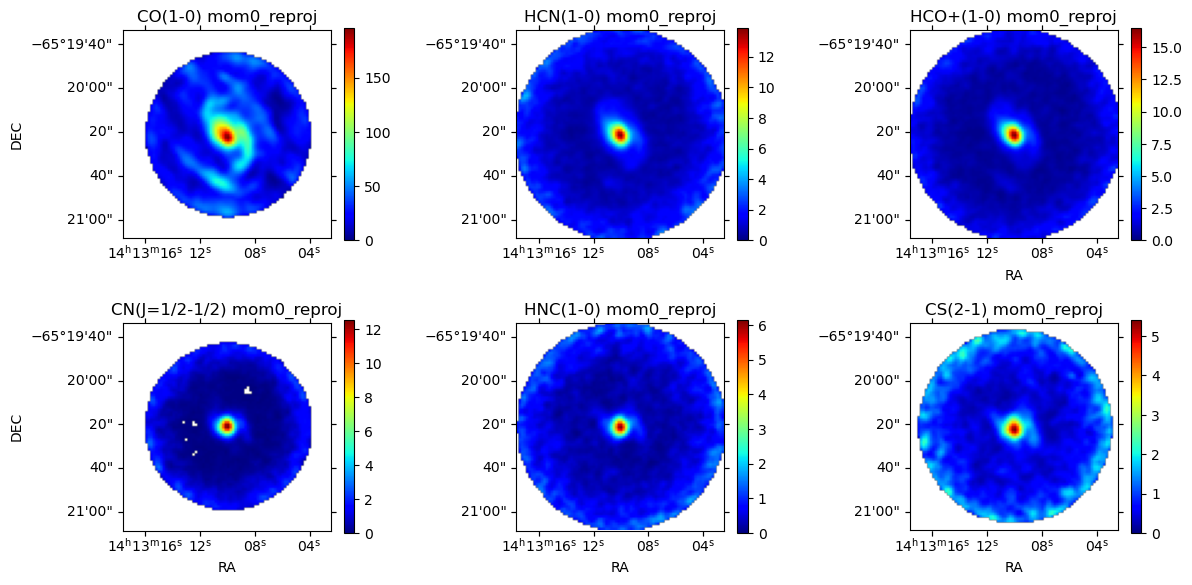

In [21]:
# show the regrid ima

print(f'pixel step : {pixelStep}')
fig_rg, ax = plt.subplots(2, 3, figsize=(12, 6), subplot_kw={'projection': CO_new_wcs}) # 是這樣設座標的
CO = ax[0, 0].imshow(CO_ima_reproj, cmap='jet', vmin=0) # 要指定物件
fig_rg.colorbar(CO, ax=ax[0, 0]) # call the obj
ax[0, 0].set_title("CO(1-0) mom0_reproj")
ax[0, 0].set_xlabel(' ')
ax[0, 0].set_ylabel('DEC')

HCN = ax[0, 1].imshow(HCN_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(HCN, ax=ax[0, 1]) 
ax[0, 1].set_title("HCN(1-0) mom0_reproj")
ax[0, 1].set_xlabel(' ')
ax[0, 1].set_ylabel(' ')

HCO = ax[0, 2].imshow(HCO_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(HCO, ax=ax[0, 2]) 
ax[0, 2].set_title("HCO+(1-0) mom0_reproj")
ax[0, 2].set_xlabel('RA')
ax[0, 2].set_ylabel(' ')

CN = ax[1, 0].imshow(CN_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(CN, ax=ax[1, 0]) 
ax[1, 0].set_title("CN(J=1/2-1/2) mom0_reproj")
ax[1, 0].set_xlabel('RA')
ax[1, 0].set_ylabel('DEC')

HNC = ax[1, 1].imshow(HNC_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(HNC, ax=ax[1, 1]) 
ax[1, 1].set_title("HNC(1-0) mom0_reproj")
ax[1, 1].set_xlabel('RA')
ax[1, 1].set_ylabel(' ')

CS2 = ax[1, 2].imshow(CS2_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(CS2, ax=ax[1, 2]) 
ax[1, 2].set_title("CS(2-1) mom0_reproj")
ax[1, 2].set_xlabel('RA')
ax[1, 2].set_ylabel(' ')

plt.tight_layout() # 神奇妙妙工具
plt.show()

In [22]:
# ratio mapS

# HCN/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_HCNCO = np.where(CO_ima_reproj>2*10**(-3), HCN_ima_reproj/CO_ima_reproj, np.nan)
    #ratioMap = np.where(CO_ima_reproj!=0, HCN_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_HCNCO = np.where(ratioMap_HCNCO>2.3, np.nan, ratioMap_HCNCO) # 撇掉一些浮沫
    ratioMap_HCNCO = np.where(ratioMap_HCNCO<-4, np.nan, ratioMap_HCNCO)

# HCO+/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_HCOCO = np.where(CO_ima_reproj>2*10**(-3), HCO_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_HCOCO = np.where(ratioMap_HCOCO>2.3, np.nan, ratioMap_HCOCO)
    ratioMap_HCOCO = np.where(ratioMap_HCOCO<-4, np.nan, ratioMap_HCOCO)

# CN/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_CNCO = np.where(CO_ima_reproj>2*10**(-3), CN_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_CNCO = np.where(ratioMap_CNCO>2.3, np.nan, ratioMap_CNCO)
    ratioMap_CNCO = np.where(ratioMap_CNCO<-4, np.nan, ratioMap_CNCO)

# HNC/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_HNCCO = np.where(CO_ima_reproj>2*10**(-3), HNC_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_HNCCO = np.where(ratioMap_HNCCO>2.3, np.nan, ratioMap_HNCCO)
    ratioMap_HNCCO = np.where(ratioMap_HNCCO<-4, np.nan, ratioMap_HNCCO)

# CS(2-1)/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_CS2CO = np.where(CO_ima_reproj>2*10**(-3), CS2_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_CS2CO = np.where(ratioMap_CS2CO>2.3, np.nan, ratioMap_CS2CO)
    ratioMap_CS2CO = np.where(ratioMap_CS2CO<-4, np.nan, ratioMap_CS2CO)



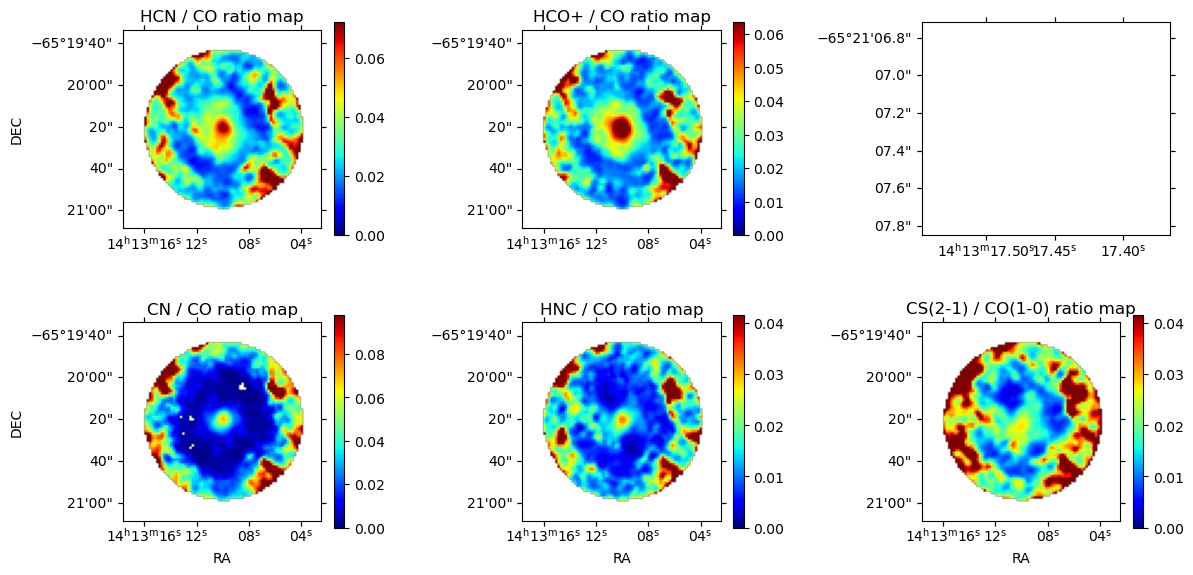

In [23]:
# show ratio maps
# 一坨

fig_ratio, ax = plt.subplots(2, 3, figsize=(12, 6), subplot_kw={'projection': CO_new_wcs})
HCNCO = ax[0, 0].imshow(ratioMap_HCNCO, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap_HCNCO, 95)) # 要指定物件
fig_ratio.colorbar(HCNCO, ax=ax[0, 0]) # call the obj
ax[0, 0].set_title("HCN / CO ratio map")
ax[0, 0].set_xlabel(' ')
ax[0, 0].set_ylabel('DEC')

HCOCO = ax[0, 1].imshow(ratioMap_HCOCO, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap_HCOCO, 95))
fig_ratio.colorbar(HCOCO, ax=ax[0, 1]) 
ax[0, 1].set_title("HCO+ / CO ratio map")
ax[0, 1].set_xlabel(' ')
ax[0, 1].set_ylabel(' ')

CNCO = ax[1, 0].imshow(ratioMap_CNCO, origin='lower', cmap='jet', vmin=0,vmax=np.nanpercentile(ratioMap_CNCO, 95))
fig_ratio.colorbar(CNCO, ax=ax[1, 0]) 
ax[1, 0].set_title("CN / CO ratio map")
ax[1, 0].set_xlabel('RA')
ax[1, 0].set_ylabel('DEC')

HNCCO = ax[1, 1].imshow(ratioMap_HNCCO, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap_HNCCO, 95))
fig_ratio.colorbar(HNCCO, ax=ax[1, 1]) 
ax[1, 1].set_title("HNC / CO ratio map")
ax[1, 1].set_xlabel('RA')
ax[1, 1].set_ylabel(' ')

CS2CO = ax[1, 2].imshow(ratioMap_CS2CO, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap_HNCCO, 95))
fig_ratio.colorbar(CS2CO, ax=ax[1, 2]) 
ax[1, 2].set_title("CS(2-1) / CO(1-0) ratio map")
ax[1, 2].set_xlabel('RA')
ax[1, 2].set_ylabel(' ')

ax[0, 2].set_xlabel(' ')
ax[0, 2].set_ylabel(' ')

plt.tight_layout() # 神奇妙妙工具
plt.show()

In [24]:
# save all file

# regrid
Save_as_FITS(f'CO-1-0_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', CO_ima_reproj, CO_new_header, CO_new_header, False)
Save_as_FITS(f'HCN-1-0_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', HCN_ima_reproj, CO_new_header, HCN_new_header, False)
Save_as_FITS(f'HCO+-1-0_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', HCO_ima_reproj, HCO_new_header, HCO_new_header, False)
Save_as_FITS(f'CN-J12-12_mom0_smoothed-4545_sigma0.8_regrid{pixelStep}.fits', CN_ima_reproj, CN_new_header, CN_new_header, False)
Save_as_FITS(f'HNC-1-0_mom0_smoothed-4545_sigma0.4_regrid{pixelStep}.fits', HNC_ima_reproj, HNC_new_header, HNC_new_header, False)
Save_as_FITS(f'CS-J2-1_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', CS2_ima_reproj, CS2_new_header, CS2_new_header, False)

# ratio
Save_as_FITS(f"HCN-CO_ratio_sigma0.2-0.2_regrid{pixelStep}", ratioMap_HCNCO, CO_new_header, CO_new_header, False)
Save_as_FITS(f"HCO+-CO_ratio_sigma0.2-0.2_regrid{pixelStep}", ratioMap_HCOCO, CO_new_header, CO_new_header, False)
Save_as_FITS(f"CN-CO_ratio_sigma0.8-0.2_regrid{pixelStep}", ratioMap_CNCO, CO_new_header, CO_new_header, False)
Save_as_FITS(f"HNC-CO_ratio_sigma0.4-0.2_regrid{pixelStep}", ratioMap_HNCCO, CO_new_header, CO_new_header, False)
Save_as_FITS(f"CS(2-1)-CO(1-0)_ratio_sigma0.2-0.2_regrid{pixelStep}", ratioMap_CS2CO, CO_new_header, CO_new_header, False)

Successfully saved a new FITS file as CO-1-0_mom0_smoothed-4545_sigma0.2_regrid1.13.fits.fits
Successfully saved a new FITS file as HCN-1-0_mom0_smoothed-4545_sigma0.2_regrid1.13.fits.fits
Successfully saved a new FITS file as HCO+-1-0_mom0_smoothed-4545_sigma0.2_regrid1.13.fits.fits
Successfully saved a new FITS file as CN-J12-12_mom0_smoothed-4545_sigma0.8_regrid1.13.fits.fits
Successfully saved a new FITS file as HNC-1-0_mom0_smoothed-4545_sigma0.4_regrid1.13.fits.fits
Successfully saved a new FITS file as CS-J2-1_mom0_smoothed-4545_sigma0.2_regrid1.13.fits.fits
Successfully saved a new FITS file as HCN-CO_ratio_sigma0.2-0.2_regrid1.13.fits
Successfully saved a new FITS file as HCO+-CO_ratio_sigma0.2-0.2_regrid1.13.fits
Successfully saved a new FITS file as CN-CO_ratio_sigma0.8-0.2_regrid1.13.fits
Successfully saved a new FITS file as HNC-CO_ratio_sigma0.4-0.2_regrid1.13.fits
Successfully saved a new FITS file as CS(2-1)-CO(1-0)_ratio_sigma0.2-0.2_regrid1.13.fits
